🚀 Monochromatic Experiment on cuda
Wavelength | Theta  | Gamma  | Acc   
---------------------------------------------
2          | 3.14   | 0.1    | 0.46
2          | 3.14   | 0.5    | 0.62
2          | 3.14   | 1.0    | 0.60
2          | 3.14   | 2.0    | 0.42
2          | 3.14   | 4.0    | 0.33
4          | 1.57   | 0.1    | 0.46
4          | 1.57   | 0.5    | 0.49
4          | 1.57   | 1.0    | 0.51
4          | 1.57   | 2.0    | 0.40
4          | 1.57   | 4.0    | 0.27
8          | 0.78   | 0.1    | 0.48
8          | 0.78   | 0.5    | 0.53
8          | 0.78   | 1.0    | 0.50
8          | 0.78   | 2.0    | 0.41
8          | 0.78   | 4.0    | 0.30
16         | 0.39   | 0.1    | 0.51
16         | 0.39   | 0.5    | 0.51
16         | 0.39   | 1.0    | 0.51
16         | 0.39   | 2.0    | 0.42
16         | 0.39   | 4.0    | 0.29
32         | 0.19   | 0.1    | 0.48
32         | 0.19   | 0.5    | 0.55
32         | 0.19   | 1.0    | 0.52
32         | 0.19   | 2.0    | 0.40
32         | 0.19

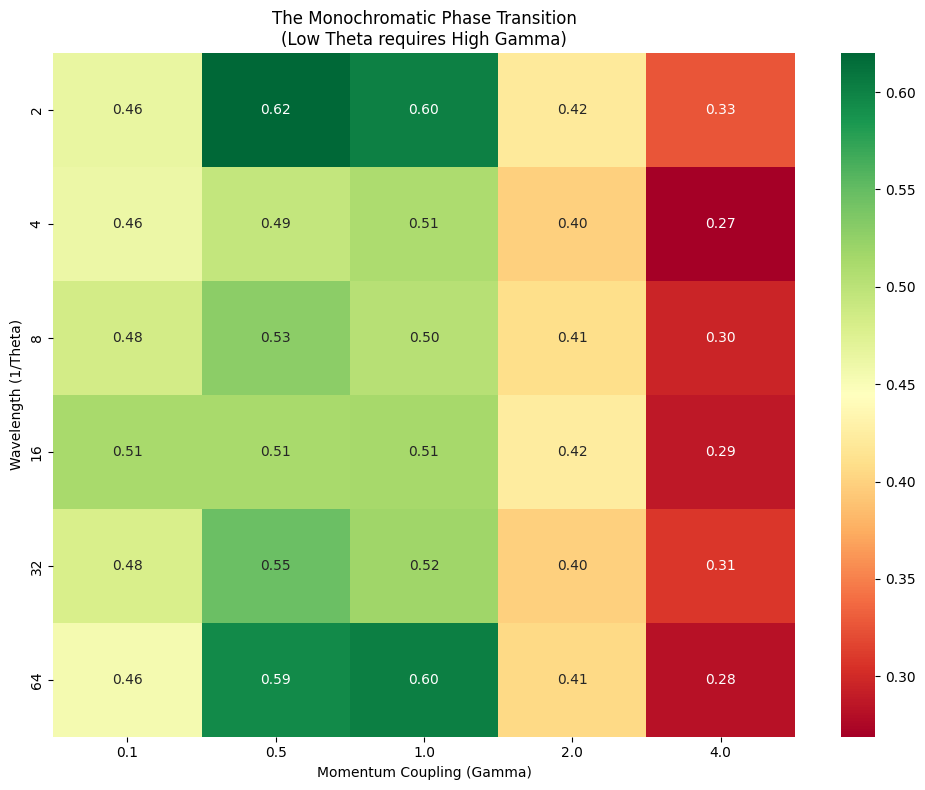

In [ ]:
# ============================================================================
# MONOCHROMATIC ROPE EXPERIMENT: ISOLATING THE SPECTRAL CUTOFF (Reference: Appendix-F)
# ============================================================================
# A "Lab Rat" model with a single, manually controlled RoPE frequency theta.
# This prevents the model from "frequency hopping" to evade the phase transition.
#
# FIXES:
# 1. Dataset Slicing: Explicit bounds [0 : 2*length : 2] to avoid shape mismatch.
# 2. Safety: Added explicit types and device checks.
# Kingsuk Maitra, Qualcomm Cloud AI Division
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import warnings
import sys

# Configuration
warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Monochromatic Experiment on {DEVICE}")

# ----------------------------------------------------------------------------
# 1. THE MONOCHROMATIC ROPE (Single Frequency)
# ----------------------------------------------------------------------------

class MonochromaticRoPE(nn.Module):
    """
    Hard-coded RoPE that uses a SINGLE scalar frequency `theta`
    for ALL dimensions. No spectral diversity allowed.
    """
    def __init__(self, dim: int, theta: float, max_len: int = 5000):
        super().__init__()
        self.dim = dim
        self.theta = theta
        self.max_len = max_len

        # Create a "flat" frequency spectrum (all dims have same theta)
        # shape: [Dim/2]
        inv_freq = torch.full((dim // 2,), theta)
        self.register_buffer('inv_freq', inv_freq)
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.shape[1]
        device = x.device

        if self.cos_cached is None or seq_len > self.cos_cached.shape[1]:
            t = torch.arange(max(seq_len, self.max_len), device=device).float()
            freqs = torch.outer(t, self.inv_freq) # [Len, Dim/2]
            emb = freqs
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]

        cos = self.cos_cached[:, :seq_len, :, :]
        sin = self.sin_cached[:, :seq_len, :, :]

        x1 = x[..., :self.dim//2]
        x2 = x[..., self.dim//2:]

        return torch.cat((x1 * cos - x2 * sin, x1 * sin + x2 * cos), dim=-1)

# ----------------------------------------------------------------------------
# 2. MOMENTUM ATTENTION (Rigorous Implementation)
# ----------------------------------------------------------------------------

class MomentumAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, gamma: float, theta: float):
        super().__init__()
        self.d_head = d_model // n_heads
        self.n_heads = n_heads
        self.gamma = gamma
        self.scale = 1.0 / math.sqrt(self.d_head)

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        # Monochromatic RoPE
        self.rope = MonochromaticRoPE(self.d_head, theta)

    def forward(self, x: torch.Tensor, mask=None):
        B, L, D = x.shape
        q = self.W_q(x).reshape(B, L, self.n_heads, self.d_head)
        k = self.W_k(x).reshape(B, L, self.n_heads, self.d_head)
        v = self.W_v(x).reshape(B, L, self.n_heads, self.d_head)

        # RoPE First
        q_rot = self.rope(q)
        k_rot = self.rope(k)

        # Kinematic Momentum
        p_q = torch.zeros_like(q_rot)
        p_k = torch.zeros_like(k_rot)
        if L > 1:
            p_q[:, 1:] = q_rot[:, 1:] - q_rot[:, :-1]
            p_k[:, 1:] = k_rot[:, 1:] - k_rot[:, :-1]

        # Shear
        q_hat = q_rot + self.gamma * p_q
        k_hat = k_rot + self.gamma * p_k

        # Attention
        # Transpose to [B, H, L, D]
        q_hat = q_hat.transpose(1, 2)
        k_hat = k_hat.transpose(1, 2)

        scores = torch.matmul(q_hat, k_hat.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)

        # Values
        out = torch.matmul(attn, v.transpose(1, 2)).transpose(1, 2).reshape(B, L, D)
        return self.W_o(out)

# ----------------------------------------------------------------------------
# 3. EXPERIMENT: THE SPECTRAL SWEEP
# ----------------------------------------------------------------------------

class ARDataset(Dataset):
    def __init__(self, n, vocab, length):
        self.data = []
        for _ in range(n):
            keys = torch.randperm(vocab // 2)[:length]
            vals = torch.randint(vocab // 2, vocab, (length,))

            # Sequence structure: K, V, K, V ... Q
            # Total len: 2*length + 1
            seq = torch.zeros(length * 2 + 1, dtype=torch.long)

            # FIX: Explicit bounds to match tensor sizes
            # Keys go into 0, 2, 4... (length items)
            seq[0 : 2*length : 2] = keys

            # Vals go into 1, 3, 5... (length items)
            seq[1 : 2*length : 2] = vals

            # Query is the last token
            idx = torch.randint(0, length, (1,)).item()
            seq[-1] = keys[idx]
            self.data.append((seq, vals[idx]))

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def run_monochromatic_sweep():
    # Grid: Gamma vs Theta
    gammas = [0.1, 0.5, 1.0, 2.0, 4.0]

    # Thetas corresponding to wavelengths [2, 4, 8, 16, 32, 64]
    # theta = 2*pi / lambda
    # 2 -> 3.14 (Nyquist), 64 -> 0.09 (Long Range)
    thetas = [3.14, 1.57, 0.78, 0.39, 0.19, 0.09]
    wavelengths = [2, 4, 8, 16, 32, 64]

    results = []

    print(f"{'Wavelength':<10} | {'Theta':<6} | {'Gamma':<6} | {'Acc':<6}")
    print("-" * 45)

    for idx, theta in enumerate(thetas):
        wl = wavelengths[idx]
        for gamma in gammas:
            # Train a fresh monochromatic model
            model = nn.Sequential(
                nn.Embedding(128, 64),
                MomentumAttention(64, 2, gamma, theta), # Single layer
                nn.LayerNorm(64),
                nn.Linear(64, 128)
            ).to(DEVICE)

            # Fast Train
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            # Chain Length 8 is fixed to isolate frequency effect
            ds = ARDataset(1000, 128, 8)
            dl = DataLoader(ds, batch_size=32, shuffle=True)

            model.train()
            # 5 Epochs is enough for AR
            for ep in range(5):
                for x, y in dl:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    logits = model(x)[:, -1]
                    loss = F.cross_entropy(logits, y)
                    opt.zero_grad(); loss.backward(); opt.step()

            # Eval
            correct = 0
            with torch.no_grad():
                for x, y in dl:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    pred = model(x)[:, -1].argmax(-1)
                    correct += (pred == y).sum().item()
            acc = correct / 1000

            print(f"{wl:<10} | {theta:<6.2f} | {gamma:<6.1f} | {acc:.2f}")
            results.append({'Wavelength': wl, 'Theta': theta, 'Gamma': gamma, 'Accuracy': acc})

    return pd.DataFrame(results)

if __name__ == "__main__":
    df = run_monochromatic_sweep()

    # Plot
    piv = df.pivot(index='Wavelength', columns='Gamma', values='Accuracy')
    plt.figure(figsize=(10, 8))
    sns.heatmap(piv, annot=True, cmap='RdYlGn', fmt=".2f")
    plt.title("The Monochromatic Phase Transition\n(Low Theta requires High Gamma)")
    plt.ylabel("Wavelength (1/Theta)")
    plt.xlabel("Momentum Coupling (Gamma)")
    plt.tight_layout()
    plt.show()